# U-Net train
* 데이터셋은 ISBI 2012 EM Segmentation Challenge

In [111]:
# import
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff # TIF 파일 처리 라이브러리

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm


# 데이터셋 불러오기

In [102]:
# 데이터 로드 함수
def load_data(volume_path, labels_path=None):
    """이미지 및 라벨 데이터를 로드합니다."""
    volume = imread(volume_path)  # (30, 512, 512) 크기
    if labels_path:
        labels = imread(labels_path)  # (30, 512, 512) 크기
        return volume, labels
    return volume

In [103]:
train_volume_path = "/kaggle/input/isbi2012/test-volume.tif"
train_labels_path = "/kaggle/input/isbi2012/train-labels.tif"
test_volume_path = "/kaggle/input/isbi2012/train-volume.tif"

In [104]:
# 데이터 로드
train_images, train_labels = load_data(train_volume_path, train_labels_path)
test_images = load_data(test_volume_path)

In [105]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train masks Shape: {train_masks.shape}")
print(f"Test Images Shape: {test_images.shape}")

Train Images Shape: (30, 512, 512)
Train masks Shape: (30, 512, 512)
Test Images Shape: (30, 512, 512)


# 데이터셋 시각화

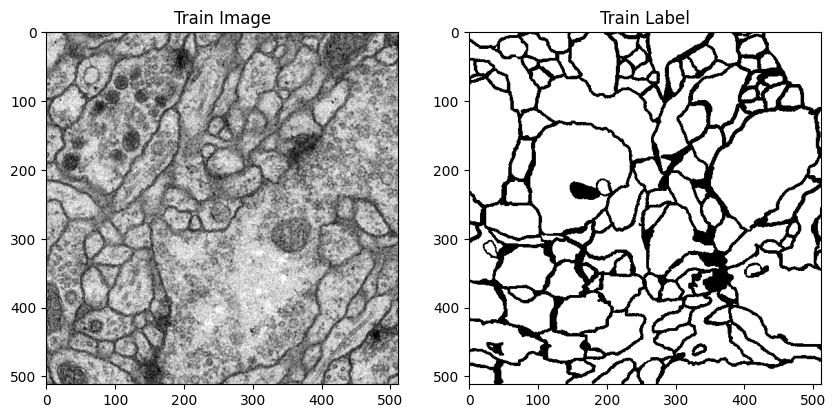

In [106]:
index = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[index], cmap='gray')
plt.title("Train Image")
plt.subplot(1, 2, 2)
plt.imshow(train_masks[index], cmap='gray')
plt.title("Train Label")
plt.show()

# 데이터 전처리

In [107]:
# 데이터 전처리 함수
def preprocess_data(images, labels=None, input_size=(572, 572), output_size=(388, 388)):
    """이미지 및 라벨 데이터를 전처리합니다."""
    # 이미지 전처리
    images = np.array([resize(img, input_size, mode='constant', preserve_range=True) for img in images])
    images = images / 255.0  # Normalize to [0, 1]
    images = images[:, np.newaxis, ...]  # Add channel dimension: (N, 1, H, W)

    if labels is not None:
        labels = np.array([resize(lbl, output_size, mode='constant', preserve_range=True) for lbl in labels])
        labels = labels / 255.0  # Normalize to [0, 1]
        labels = labels[:, np.newaxis, ...]  # Add channel dimension
        return images, labels

    return images

# 전처리 수행
X_train, y_train = preprocess_data(train_images, train_labels)
X_test = preprocess_data(test_images)

# 결과 확인
print(f"Processed Train Images Shape: {X_train.shape}")
print(f"Processed Train Labels Shape: {y_train.shape}")
print(f"Processed Test Images Shape: {X_test.shape}")


Processed Train Images Shape: (30, 1, 572, 572)
Processed Train Labels Shape: (30, 1, 388, 388)
Processed Test Images Shape: (30, 1, 572, 572)


# Dataset , DataLoader 정의

In [108]:
from torch.utils.data import Dataset, DataLoader

class ISBIDataset(Dataset):
    def __init__(self, images, labels=None):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return image, label
        return image

# Train/Validation 분리
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Dataset 및 DataLoader 생성
train_dataset = ISBIDataset(X_train_split, y_train_split)
val_dataset = ISBIDataset(X_val_split, y_val_split)
test_dataset = ISBIDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# 데이터 배치 확인
for images, labels in train_loader:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels Shape: {labels.shape}")
    break


Batch Images Shape: torch.Size([2, 1, 572, 572])
Batch Labels Shape: torch.Size([2, 1, 388, 388])


# 시각화

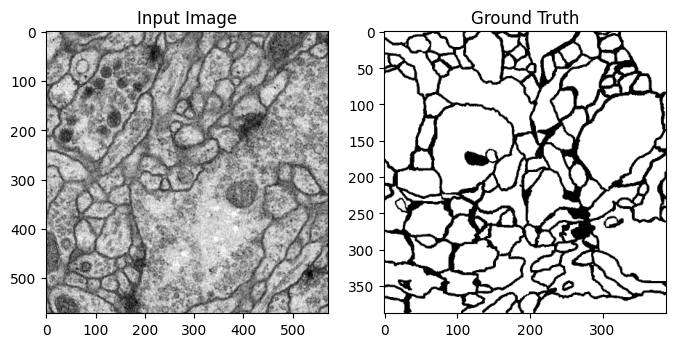

In [109]:
def visualize_data(images, labels=None, idx=0):
    """이미지와 라벨을 시각화합니다."""
    plt.figure(figsize=(8, 4))
    
    # 이미지 시각화
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title("Input Image")
    
    if labels is not None:
        # 라벨 시각화
        plt.subplot(1, 2, 2)
        plt.imshow(labels[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth")
    
    plt.show()

# 훈련 데이터 시각화
visualize_data(X_train, y_train, idx=0)


# Model 정의 및 손실함수 옵티마이저 설정

In [117]:
# U-Net Architecture
# Contracting path - Conv(3x3 kernel, stride:1) x 2
# Bottle neck - Conv(3x3 kernel, stride: 1) x 2
# Expanding path - Up-Conv(2x2kernel, stride:2) after copy and crop Conv(3x3 kernel, stride:1)x2


####### import #######
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
####### import ######




########  UNet  #########
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # (Convoultion + BatchNormalization + ReLU)
        # BatchNormalization 사용 이유: 신경망의 각 레이어는 학습 중에 입력 분포가 변화하기 때문에 이러한 변화는
        # 학습을 불안정하게 하고 새로운 입력 분포에 적응하기 어렵다. 각 레이어의 입력을 정규화하므로 변화를 줄임.
        def CBR2d(input_channel, output_channel, kernel_size=3, stride=1):
            layer = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size= kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channel),
                nn.ReLU()
            )
            return layer

        # Contracting path
        # layer1 1 -> 64
        self.conv1 = nn.Sequential(CBR2d(1, 64), CBR2d(64, 64))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # layer2 64 ->128
        self.conv2 = nn.Sequential(CBR2d(64, 128), CBR2d(128, 128))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # layer3 128 -> 256
        self.conv3 = nn.Sequential(CBR2d(128, 256), CBR2d(256, 256))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # layer4 256 -> 512
        self.conv4 = nn.Sequential(CBR2d(256, 512), CBR2d(512, 512), nn.Dropout(p=0.5)) # Dropout 과적합 방지
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Bottleneck
        # 512 -> 1024
        self.bottleNeck = nn.Sequential(CBR2d(512, 1024), CBR2d(1024, 1024))


        # Expanding path
        # 1nd UpSampling 1024 -> 512
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.ex_conv1 = nn.Sequential(CBR2d(1024, 512), CBR2d(512, 512))

        # 2nd UpSampling 512 -> 256
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.ex_conv2 = nn.Sequential(CBR2d(512, 256), CBR2d(256, 256))

        # 3nd UpSampling 256 -> 128
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.ex_conv3 = nn.Sequential(CBR2d(256, 128), CBR2d(128, 128))

        # 4nd UpSampling 128 -> 64
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.ex_conv4 = nn.Sequential(CBR2d(128, 64), CBR2d(64, 64))


        # Final Layer
        self.fc = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, x):
        # Contracting path
        layer1 = self.conv1(x)
        out = self.pool1(layer1)

        layer2 = self.conv2(out)
        out = self.pool2(layer2)

        layer3 = self.conv3(out)
        out = self.pool3(layer3)

        layer4 = self.conv4(out)
        out = self.pool4(layer4)

        # bottleNeck
        bottleneck = self.bottleNeck(out)


        # Expanding path
        # Center_crop: layer를 upconv의 출력크기만큼 중앙 크롭하여 결합
        upconv1 = self.upconv1(bottleneck)
        cat1 = torch.cat((center_crop(layer4, [upconv1.shape[2], upconv1.shape[3]]), upconv1), dim=1)
        ex_layer1 = self.ex_conv1(cat1)

        upconv2 = self.upconv2(ex_layer1)
        cat2 = torch.cat((center_crop(layer3, [upconv2.shape[2], upconv2.shape[3]]), upconv2), dim=1)
        ex_layer2 = self.ex_conv2(cat2)

        upconv3 = self.upconv3(ex_layer2)
        cat3 = torch.cat((center_crop(layer2, [upconv3.shape[2], upconv3.shape[3]]), upconv3), dim=1)
        ex_layer3 = self.ex_conv3(cat3)

        upconv4 = self.upconv4(ex_layer3)
        cat4 = torch.cat((center_crop(layer1, [upconv4.shape[2], upconv4.shape[3]]), upconv4), dim=1)
        ex_layer4 = self.ex_conv4(cat4)

        # output layer
        out = self.fc(ex_layer4)
        return out

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss() # 이진 분류용 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 픽셀 단위 정확도 계산 함수

In [119]:
# 픽셀 단위 정확도 계산 함수
def pixel_accuracy(pred, target):
    pred = torch.sigmoid(pred) > 0.5  # Threshold 적용
    correct = (pred == target).float()
    return correct.sum() / correct.numel()

In [27]:
# # Dice_score 는 Segmentation Task를 진행하면 흔하게 접하게 되는 개념
#  'Prediction과 Ground-Truth가 얼마나 겹치느냐'를 평가하는 데에 쓰인다.
# Dice Score가 1에 가까울 수록 모델의 민감도와 정밀도가 좋다는 뜻이고,
#반대로 0에 가까울 수록 민감도 또는 정밀도(둘 중 무엇인지는 실제로 값을 뽑아봐야 알 수 있음)가 안 좋다는 뜻이다.
def dice_score(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()  # 예측 값을 0 또는 1로 이진화
    intersection = (pred * target).sum()  # 교집합
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-6)  # Dice Score 계산

# 학습 루프

In [120]:
from torchvision.transforms.functional import center_crop

num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

import torchvision.transforms.functional as TF

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = pixel_accuracy(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
    
    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = pixel_accuracy(outputs, labels)
            
            val_loss += loss.item()
            val_acc += acc.item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 1/100, Training Loss: 0.6892, Accuracy: 0.5112


Epoch 1/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


Epoch 1/100, Validation Loss: 0.6907, Accuracy: 0.4826


Epoch 2/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 2/100, Training Loss: 0.5658, Accuracy: 0.7385


Epoch 2/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Epoch 2/100, Validation Loss: 0.5913, Accuracy: 0.7434


Epoch 3/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 3/100, Training Loss: 0.5399, Accuracy: 0.7399


Epoch 3/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


Epoch 3/100, Validation Loss: 0.5731, Accuracy: 0.7037


Epoch 4/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 4/100, Training Loss: 0.5320, Accuracy: 0.7400


Epoch 4/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


Epoch 4/100, Validation Loss: 0.5721, Accuracy: 0.7235


Epoch 5/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch 5/100, Training Loss: 0.5303, Accuracy: 0.7396


Epoch 5/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


Epoch 5/100, Validation Loss: 0.5297, Accuracy: 0.7434


Epoch 6/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 6/100, Training Loss: 0.5280, Accuracy: 0.7401


Epoch 6/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Epoch 6/100, Validation Loss: 0.5244, Accuracy: 0.7434


Epoch 7/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch 7/100, Training Loss: 0.5277, Accuracy: 0.7401


Epoch 7/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 7/100, Validation Loss: 0.5243, Accuracy: 0.7434


Epoch 8/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 8/100, Training Loss: 0.5279, Accuracy: 0.7401


Epoch 8/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 8/100, Validation Loss: 0.5235, Accuracy: 0.7434


Epoch 9/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 9/100, Training Loss: 0.5276, Accuracy: 0.7401


Epoch 9/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]


Epoch 9/100, Validation Loss: 0.5240, Accuracy: 0.7434


Epoch 10/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 10/100, Training Loss: 0.5277, Accuracy: 0.7401


Epoch 10/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


Epoch 10/100, Validation Loss: 0.5237, Accuracy: 0.7434


Epoch 11/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 11/100, Training Loss: 0.5276, Accuracy: 0.7401


Epoch 11/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]


Epoch 11/100, Validation Loss: 0.5241, Accuracy: 0.7427


Epoch 12/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch 12/100, Training Loss: 0.5276, Accuracy: 0.7401


Epoch 12/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


Epoch 12/100, Validation Loss: 0.5249, Accuracy: 0.7434


Epoch 13/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch 13/100, Training Loss: 0.5275, Accuracy: 0.7399


Epoch 13/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


Epoch 13/100, Validation Loss: 0.5245, Accuracy: 0.7434


Epoch 14/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 14/100, Training Loss: 0.5281, Accuracy: 0.7401


Epoch 14/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


Epoch 14/100, Validation Loss: 0.5246, Accuracy: 0.7434


Epoch 15/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch 15/100, Training Loss: 0.5269, Accuracy: 0.7401


Epoch 15/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Epoch 15/100, Validation Loss: 0.5247, Accuracy: 0.7434


Epoch 16/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 16/100, Training Loss: 0.5271, Accuracy: 0.7401


Epoch 16/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Epoch 16/100, Validation Loss: 0.5241, Accuracy: 0.7434


Epoch 17/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 17/100, Training Loss: 0.5271, Accuracy: 0.7401


Epoch 17/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 17/100, Validation Loss: 0.5237, Accuracy: 0.7434


Epoch 18/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 18/100, Training Loss: 0.5271, Accuracy: 0.7401


Epoch 18/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 18/100, Validation Loss: 0.5236, Accuracy: 0.7434


Epoch 19/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 19/100, Training Loss: 0.5270, Accuracy: 0.7401


Epoch 19/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


Epoch 19/100, Validation Loss: 0.5236, Accuracy: 0.7434


Epoch 20/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 20/100, Training Loss: 0.5268, Accuracy: 0.7401


Epoch 20/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 20/100, Validation Loss: 0.5236, Accuracy: 0.7434


Epoch 21/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 21/100, Training Loss: 0.5273, Accuracy: 0.7401


Epoch 21/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 21/100, Validation Loss: 0.5251, Accuracy: 0.7434


Epoch 22/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 22/100, Training Loss: 0.5265, Accuracy: 0.7401


Epoch 22/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 22/100, Validation Loss: 0.5277, Accuracy: 0.7434


Epoch 23/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 23/100, Training Loss: 0.5269, Accuracy: 0.7401


Epoch 23/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 23/100, Validation Loss: 0.5235, Accuracy: 0.7434


Epoch 24/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 24/100, Training Loss: 0.5264, Accuracy: 0.7401


Epoch 24/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 24/100, Validation Loss: 0.5252, Accuracy: 0.7428


Epoch 25/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 25/100, Training Loss: 0.5267, Accuracy: 0.7401


Epoch 25/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 25/100, Validation Loss: 0.5235, Accuracy: 0.7434


Epoch 26/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 26/100, Training Loss: 0.5267, Accuracy: 0.7401


Epoch 26/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 26/100, Validation Loss: 0.5240, Accuracy: 0.7434


Epoch 27/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 27/100, Training Loss: 0.5264, Accuracy: 0.7401


Epoch 27/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Epoch 27/100, Validation Loss: 0.5247, Accuracy: 0.7433


Epoch 28/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 28/100, Training Loss: 0.5263, Accuracy: 0.7401


Epoch 28/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Epoch 28/100, Validation Loss: 0.5245, Accuracy: 0.7434


Epoch 29/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 29/100, Training Loss: 0.5260, Accuracy: 0.7401


Epoch 29/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 29/100, Validation Loss: 0.5257, Accuracy: 0.7427


Epoch 30/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 30/100, Training Loss: 0.5262, Accuracy: 0.7401


Epoch 30/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 30/100, Validation Loss: 0.5245, Accuracy: 0.7434


Epoch 31/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 31/100, Training Loss: 0.5260, Accuracy: 0.7401


Epoch 31/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 31/100, Validation Loss: 0.5260, Accuracy: 0.7434


Epoch 32/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 32/100, Training Loss: 0.5258, Accuracy: 0.7401


Epoch 32/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 32/100, Validation Loss: 0.5254, Accuracy: 0.7434


Epoch 33/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 33/100, Training Loss: 0.5253, Accuracy: 0.7401


Epoch 33/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Epoch 33/100, Validation Loss: 0.5243, Accuracy: 0.7434


Epoch 34/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 34/100, Training Loss: 0.5253, Accuracy: 0.7401


Epoch 34/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 34/100, Validation Loss: 0.5262, Accuracy: 0.7434


Epoch 35/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 35/100, Training Loss: 0.5249, Accuracy: 0.7401


Epoch 35/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Epoch 35/100, Validation Loss: 0.5236, Accuracy: 0.7434


Epoch 36/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 36/100, Training Loss: 0.5249, Accuracy: 0.7401


Epoch 36/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 36/100, Validation Loss: 0.5252, Accuracy: 0.7434


Epoch 37/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 37/100, Training Loss: 0.5256, Accuracy: 0.7401


Epoch 37/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 37/100, Validation Loss: 0.5248, Accuracy: 0.7434


Epoch 38/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 38/100, Training Loss: 0.5256, Accuracy: 0.7401


Epoch 38/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 38/100, Validation Loss: 0.5239, Accuracy: 0.7434


Epoch 39/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 39/100, Training Loss: 0.5250, Accuracy: 0.7401


Epoch 39/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 39/100, Validation Loss: 0.5254, Accuracy: 0.7434


Epoch 40/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 40/100, Training Loss: 0.5235, Accuracy: 0.7401


Epoch 40/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 40/100, Validation Loss: 0.5257, Accuracy: 0.7434


Epoch 41/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 41/100, Training Loss: 0.5233, Accuracy: 0.7401


Epoch 41/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 41/100, Validation Loss: 0.5284, Accuracy: 0.7434


Epoch 42/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 42/100, Training Loss: 0.5232, Accuracy: 0.7401


Epoch 42/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 42/100, Validation Loss: 0.5245, Accuracy: 0.7434


Epoch 43/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 43/100, Training Loss: 0.5225, Accuracy: 0.7401


Epoch 43/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 43/100, Validation Loss: 0.5270, Accuracy: 0.7434


Epoch 44/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 44/100, Training Loss: 0.5226, Accuracy: 0.7401


Epoch 44/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 44/100, Validation Loss: 0.5246, Accuracy: 0.7434


Epoch 45/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 45/100, Training Loss: 0.5213, Accuracy: 0.7401


Epoch 45/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 45/100, Validation Loss: 0.5251, Accuracy: 0.7434


Epoch 46/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 46/100, Training Loss: 0.5218, Accuracy: 0.7401


Epoch 46/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 46/100, Validation Loss: 0.5262, Accuracy: 0.7434


Epoch 47/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 47/100, Training Loss: 0.5206, Accuracy: 0.7401


Epoch 47/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


Epoch 47/100, Validation Loss: 0.5295, Accuracy: 0.7434


Epoch 48/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 48/100, Training Loss: 0.5204, Accuracy: 0.7401


Epoch 48/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 48/100, Validation Loss: 0.5362, Accuracy: 0.7434


Epoch 49/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 49/100, Training Loss: 0.5188, Accuracy: 0.7401


Epoch 49/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 49/100, Validation Loss: 0.5272, Accuracy: 0.7434


Epoch 50/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 50/100, Training Loss: 0.5168, Accuracy: 0.7401


Epoch 50/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 50/100, Validation Loss: 0.5281, Accuracy: 0.7434


Epoch 51/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 51/100, Training Loss: 0.5194, Accuracy: 0.7401


Epoch 51/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 51/100, Validation Loss: 0.5289, Accuracy: 0.7434


Epoch 52/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 52/100, Training Loss: 0.5175, Accuracy: 0.7401


Epoch 52/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 52/100, Validation Loss: 0.5290, Accuracy: 0.7434


Epoch 53/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 53/100, Training Loss: 0.5153, Accuracy: 0.7401


Epoch 53/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 53/100, Validation Loss: 0.5399, Accuracy: 0.7434


Epoch 54/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 54/100, Training Loss: 0.5140, Accuracy: 0.7402


Epoch 54/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Epoch 54/100, Validation Loss: 0.5375, Accuracy: 0.7434


Epoch 55/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 55/100, Training Loss: 0.5135, Accuracy: 0.7397


Epoch 55/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 55/100, Validation Loss: 0.5344, Accuracy: 0.7434


Epoch 56/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 56/100, Training Loss: 0.5155, Accuracy: 0.7401


Epoch 56/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 56/100, Validation Loss: 0.5302, Accuracy: 0.7431


Epoch 57/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 57/100, Training Loss: 0.5139, Accuracy: 0.7401


Epoch 57/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 57/100, Validation Loss: 0.5955, Accuracy: 0.7433


Epoch 58/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 58/100, Training Loss: 0.5118, Accuracy: 0.7401


Epoch 58/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 58/100, Validation Loss: 0.5419, Accuracy: 0.7434


Epoch 59/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 59/100, Training Loss: 0.5099, Accuracy: 0.7400


Epoch 59/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 59/100, Validation Loss: 0.5720, Accuracy: 0.7086


Epoch 60/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 60/100, Training Loss: 0.5078, Accuracy: 0.7400


Epoch 60/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 60/100, Validation Loss: 0.5376, Accuracy: 0.7433


Epoch 61/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 61/100, Training Loss: 0.5054, Accuracy: 0.7399


Epoch 61/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 61/100, Validation Loss: 0.5292, Accuracy: 0.7434


Epoch 62/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 62/100, Training Loss: 0.5040, Accuracy: 0.7400


Epoch 62/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 62/100, Validation Loss: 0.5401, Accuracy: 0.7430


Epoch 63/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 63/100, Training Loss: 0.4993, Accuracy: 0.7393


Epoch 63/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 63/100, Validation Loss: 0.5406, Accuracy: 0.7434


Epoch 64/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 64/100, Training Loss: 0.4972, Accuracy: 0.7395


Epoch 64/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


Epoch 64/100, Validation Loss: 0.5475, Accuracy: 0.7433


Epoch 65/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 65/100, Training Loss: 0.4943, Accuracy: 0.7402


Epoch 65/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Epoch 65/100, Validation Loss: 0.5457, Accuracy: 0.7426


Epoch 66/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 66/100, Training Loss: 0.4913, Accuracy: 0.7391


Epoch 66/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 66/100, Validation Loss: 0.5667, Accuracy: 0.7430


Epoch 67/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 67/100, Training Loss: 0.4882, Accuracy: 0.7393


Epoch 67/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 67/100, Validation Loss: 0.5403, Accuracy: 0.7434


Epoch 68/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 68/100, Training Loss: 0.4851, Accuracy: 0.7395


Epoch 68/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 68/100, Validation Loss: 0.5543, Accuracy: 0.7384


Epoch 69/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 69/100, Training Loss: 0.4808, Accuracy: 0.7396


Epoch 69/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Epoch 69/100, Validation Loss: 0.5466, Accuracy: 0.7389


Epoch 70/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 70/100, Training Loss: 0.4753, Accuracy: 0.7401


Epoch 70/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Epoch 70/100, Validation Loss: 0.5464, Accuracy: 0.7336


Epoch 71/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 71/100, Training Loss: 0.4745, Accuracy: 0.7366


Epoch 71/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 71/100, Validation Loss: 0.5547, Accuracy: 0.7340


Epoch 72/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 72/100, Training Loss: 0.4718, Accuracy: 0.7379


Epoch 72/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 72/100, Validation Loss: 0.5575, Accuracy: 0.7197


Epoch 73/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 73/100, Training Loss: 0.4656, Accuracy: 0.7389


Epoch 73/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 73/100, Validation Loss: 0.5523, Accuracy: 0.7377


Epoch 74/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 74/100, Training Loss: 0.4617, Accuracy: 0.7403


Epoch 74/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 74/100, Validation Loss: 0.5564, Accuracy: 0.7388


Epoch 75/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 75/100, Training Loss: 0.4581, Accuracy: 0.7373


Epoch 75/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 75/100, Validation Loss: 0.5451, Accuracy: 0.7331


Epoch 76/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 76/100, Training Loss: 0.4503, Accuracy: 0.7372


Epoch 76/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch 76/100, Validation Loss: 0.5679, Accuracy: 0.7309


Epoch 77/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 77/100, Training Loss: 0.4430, Accuracy: 0.7376


Epoch 77/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 77/100, Validation Loss: 0.5759, Accuracy: 0.7104


Epoch 78/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 78/100, Training Loss: 0.4373, Accuracy: 0.7378


Epoch 78/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 78/100, Validation Loss: 0.5569, Accuracy: 0.7207


Epoch 79/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 79/100, Training Loss: 0.4304, Accuracy: 0.7390


Epoch 79/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 79/100, Validation Loss: 0.5759, Accuracy: 0.7006


Epoch 80/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 80/100, Training Loss: 0.4273, Accuracy: 0.7375


Epoch 80/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 80/100, Validation Loss: 0.6336, Accuracy: 0.6961


Epoch 81/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 81/100, Training Loss: 0.4129, Accuracy: 0.7403


Epoch 81/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch 81/100, Validation Loss: 0.5874, Accuracy: 0.6936


Epoch 82/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 82/100, Training Loss: 0.4026, Accuracy: 0.7398


Epoch 82/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 82/100, Validation Loss: 0.5643, Accuracy: 0.7283


Epoch 83/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 83/100, Training Loss: 0.3948, Accuracy: 0.7388


Epoch 83/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Epoch 83/100, Validation Loss: 0.5896, Accuracy: 0.6970


Epoch 84/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 84/100, Training Loss: 0.3875, Accuracy: 0.7419


Epoch 84/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch 84/100, Validation Loss: 0.6292, Accuracy: 0.7207


Epoch 85/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 85/100, Training Loss: 0.3764, Accuracy: 0.7421


Epoch 85/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 85/100, Validation Loss: 0.5798, Accuracy: 0.7251


Epoch 86/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 86/100, Training Loss: 0.3731, Accuracy: 0.7415


Epoch 86/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 86/100, Validation Loss: 0.6169, Accuracy: 0.6638


Epoch 87/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 87/100, Training Loss: 0.3638, Accuracy: 0.7468


Epoch 87/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 87/100, Validation Loss: 0.6654, Accuracy: 0.6984


Epoch 88/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 88/100, Training Loss: 0.3477, Accuracy: 0.7477


Epoch 88/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Epoch 88/100, Validation Loss: 0.6305, Accuracy: 0.6931


Epoch 89/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 89/100, Training Loss: 0.3328, Accuracy: 0.7547


Epoch 89/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Epoch 89/100, Validation Loss: 0.6398, Accuracy: 0.6903


Epoch 90/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 90/100, Training Loss: 0.3323, Accuracy: 0.7539


Epoch 90/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 90/100, Validation Loss: 0.6525, Accuracy: 0.6938


Epoch 91/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 91/100, Training Loss: 0.3166, Accuracy: 0.7573


Epoch 91/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 91/100, Validation Loss: 0.6722, Accuracy: 0.7156


Epoch 92/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 92/100, Training Loss: 0.3075, Accuracy: 0.7630


Epoch 92/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 92/100, Validation Loss: 0.6964, Accuracy: 0.6145


Epoch 93/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 93/100, Training Loss: 0.2926, Accuracy: 0.7679


Epoch 93/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 93/100, Validation Loss: 0.6553, Accuracy: 0.6872


Epoch 94/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 94/100, Training Loss: 0.2801, Accuracy: 0.7718


Epoch 94/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Epoch 94/100, Validation Loss: 0.7000, Accuracy: 0.6079


Epoch 95/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 95/100, Training Loss: 0.2700, Accuracy: 0.7760


Epoch 95/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 95/100, Validation Loss: 0.7168, Accuracy: 0.6582


Epoch 96/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 96/100, Training Loss: 0.2619, Accuracy: 0.7793


Epoch 96/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


Epoch 96/100, Validation Loss: 0.7168, Accuracy: 0.6387


Epoch 97/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 97/100, Training Loss: 0.2528, Accuracy: 0.7814


Epoch 97/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 97/100, Validation Loss: 0.7831, Accuracy: 0.5824


Epoch 98/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 98/100, Training Loss: 0.2409, Accuracy: 0.7867


Epoch 98/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 98/100, Validation Loss: 0.8008, Accuracy: 0.6372


Epoch 99/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 99/100, Training Loss: 0.2389, Accuracy: 0.7861


Epoch 99/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Epoch 99/100, Validation Loss: 0.7378, Accuracy: 0.6578


Epoch 100/100 - Training: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 100/100, Training Loss: 0.2380, Accuracy: 0.7881


Epoch 100/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

Epoch 100/100, Validation Loss: 0.8009, Accuracy: 0.6429


# 시각화

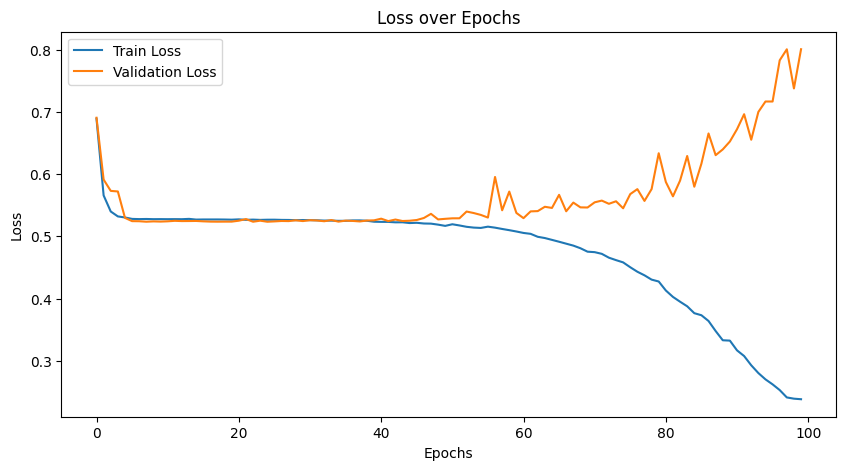

In [121]:
# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


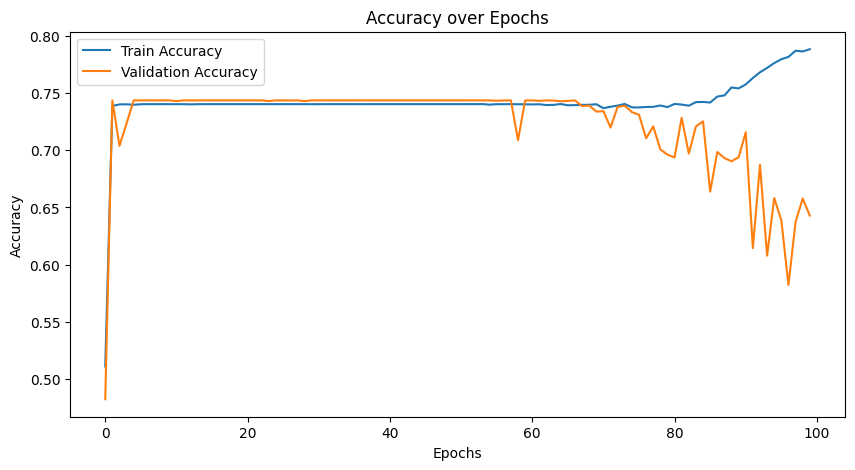

In [122]:
# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 테스트 데이터 예측 시각화

In [125]:
def visualize_segmentation(model, dataset, idx=0, device="cuda"):
    """
    GPU를 사용하여 입력 이미지, Ground Truth, 모델 예측 결과를 비교하고 시각화합니다.
    
    Args:
    - model: 학습된 모델
    - dataset: 데이터셋 (ISBIDataset 객체)
    - idx: 시각화할 데이터의 인덱스
    - device: 모델이 있는 장치 ("cuda" 또는 "cpu")
    """
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 데이터셋에서 이미지와 라벨 가져오기
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가 및 GPU로 전송
    label = label.squeeze().numpy()  # (H, W)
    
    # 모델 예측
    with torch.no_grad():
        prediction = model(image)  # Forward pass
        prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Threshold 적용 및 GPU에서 CPU로 이동

    # 시각화
    plt.figure(figsize=(12, 4))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # 예측 결과
    plt.subplot(1, 3, 3)
    plt.imshow(prediction > 0.5, cmap='gray')  # 0.5 Threshold 적용
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


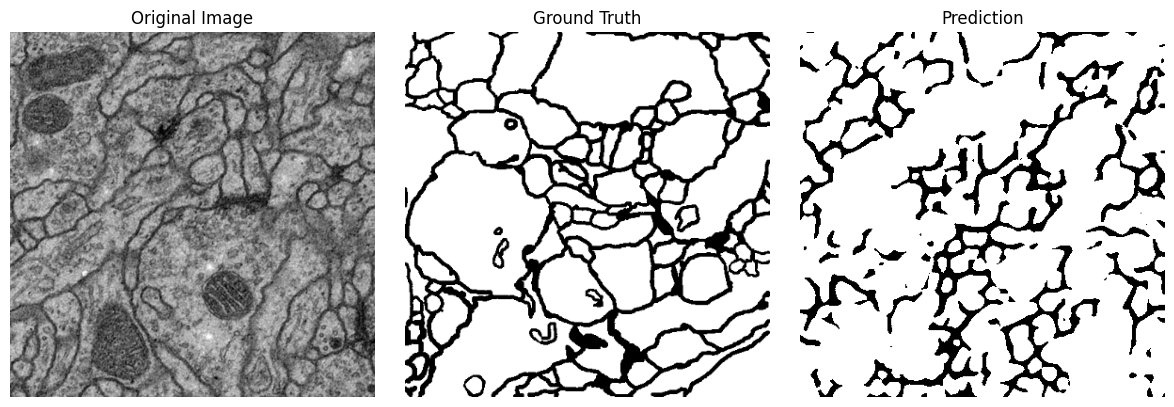

In [130]:
sample_idx = 0  # 테스트 데이터의 첫 번째 샘플

visualize_segmentation(model, val_dataset, idx=sample_idx, device=device)

# Inference

In [132]:
from skimage.io import imread
from skimage.transform import resize
import torch

def preprocess_external_image(image_path, input_size=(572, 572)):
    """
    외부 이미지를 모델 입력 형식에 맞게 전처리합니다.
    
    Args:
    - image_path: 이미지 경로
    - input_size: 모델 입력 크기 (tuple)
    
    Returns:
    - preprocessed_image: 전처리된 이미지 텐서
    """
    # 이미지 로드 및 크기 조정
    image = imread(image_path, as_gray=True)
    image_resized = resize(image, input_size, mode='constant', preserve_range=True)

    # 정규화 및 차원 추가
    image_resized = image_resized / 255.0  # Normalize to [0, 1]
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add channel & batch
    return image_tensor

# 외부 이미지 경로
external_image_path = "/kaggle/input/inference/Wilson1900Fig2.jpg"

# 전처리
external_image = preprocess_external_image(external_image_path)


In [133]:
# GPU로 데이터 전송
external_image = external_image.to(device)

# 모델 추론
model.eval()
with torch.no_grad():
    prediction = model(external_image)
    prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Threshold 적용


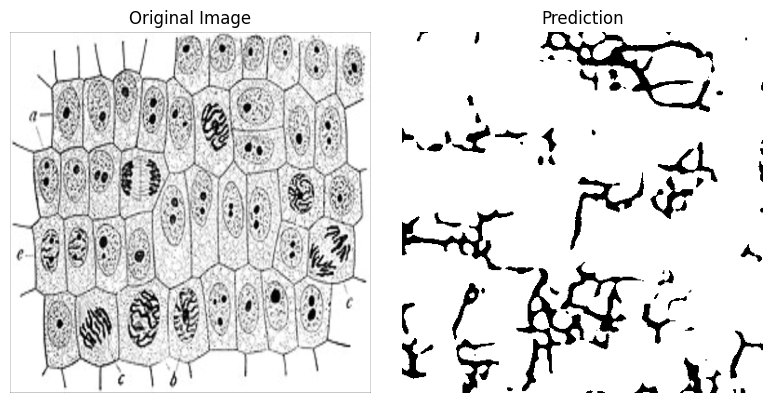

In [134]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(8, 4))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(external_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis("off")

# 예측 결과
plt.subplot(1, 2, 2)
plt.imshow(prediction > 0.5, cmap='gray')  # Threshold 적용
plt.title("Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()
